In [2]:
# This code loads the temperature and precipitation changes expected per country from the World Bank Climate API
# Source: https://datahelpdesk.worldbank.org/knowledgebase/articles/902061-climate-data-api

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from pprint import pprint
import json
from scipy.stats import sem
import math


In [3]:
climate_base_url = 'http://climatedataapi.worldbank.org/climateweb/rest/v1/country/'
countries_response = requests.get(climate_base_url).json()
countries_in_climate_api = pd.DataFrame(countries_response)

# Save
countries_in_climate_api.to_csv('6_Output/countries_in_climate_api_and_iso_codes.csv', index=False, encoding='utf-8')

# Preview
countries_in_climate_api.head()

,id,iso2,iso3,name
0,466,AF,AFG,Afghanistan
1,582,AL,ALB,Albania
2,520,DZ,DZA,Algeria
3,677,NaN,ASM,American Samoa (U.S.)
4,675,NaN,AND,Andorra


In [59]:
countries_in_climate_api.loc[countries_in_climate_api['name'] == "El Salvador"]

,id,iso2,iso3,name
63,581,SV,SLV,El Salvador


In [38]:
# Query format: http://climatedataapi.worldbank.org/climateweb/rest/v1/country/type/var/start/end/ISO3[.ext]
# Query format: http://api.worldbank.org/v2/countries/br?format=json
#base_url = 'http://api.worldbank.org/v2/countries/'        #####  DON'T USE THIS URL; NOT THE ONE WE WANT!!  ######
#countries_response = requests.get(base_url + '?format=json').json()
#pprint(countries_response[1])

country_name = []
temp_years1 = []
temp_years2 = []
startyears = [1920, 1940, 1960, 1980, 2020, 2040, 2060, 2080]                 
endyears = [1939, 1959, 1979, 1999, 2039, 2059, 2079, 2099]
countries_temp = {}
countries_years = {} # just a temporary dictionary 
                     # that will be added to the final 
                     # temperature and precipitation dataframes

for country in range(countries_in_climate_api.shape[0]):
    #print(country)
    country_name.append(countries_in_climate_api.loc[country, 'name'])
    temps = []
    temp_years1 = []
    temp_years2 = []
    for year in range(len(startyears)):
        climate_url_annualavg_temp = climate_base_url + 'annualanom/' # Average annual change (anomaly). 
                                                                      # The control period is 1961-1999 for 
                                                                      # temperature and precipitation variables, 
                                                                      # and 1961-2000 for derived statistics
        climate_url_annualavg_temp += 'tas/'
        climate_url_annualavg_temp += str(startyears[year]) + '/' 
        climate_url_annualavg_temp +=  str(endyears[year]) + '/'
        climate_url_annualavg_temp += countries_in_climate_api.loc[country, 'iso3']
        #print(climate_url_annualavg_temp)
        try:
            climate_annualavg_temp = requests.get(climate_url_annualavg_temp).json()
        except:
            continue
        #pprint(climate_annualavg_temp)
        for temp in range(len(climate_annualavg_temp)):
            temps.append(climate_annualavg_temp[temp]['annualData'][0])
            temp_years1.append(startyears[year])
            temp_years2.append(endyears[year])
    countries_temp[countries_in_climate_api.loc[country, 'name']] = temps
    countries_years[countries_in_climate_api.loc[country, 'name']] = [str(temp_years1[i]) + "-" + str(temp_years2[i])
                                                                      for i in range(len(temp_years1))]

 

In [39]:
print(len(list(countries_temp.keys())))
pprint(sorted(countries_temp.keys())) # b/c Piro asked us to :D

241
['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa (U.S.)',
 'Andorra',
 'Angola',
 'Anguilla (U.K.)',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba (Neth.)',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda (U.K.)',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Indian Ocean Territory (U.K.)',
 'British Virgin Islands (U.K.)',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands (U.K.)',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island (Aus.)',
 'Cocos (Keeling) Islands (Aus.)',
 'Colombia',
 'Comoros',
 'Congo',
 'Congo, Democratic Republic of',
 'Cook Islands (N.Z.)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Disputed Area - China and India',
 'Djibouti',
 'Dominica',
 'Do

In [120]:
# We may have countries in the countries_temp dictionary that are empty; 
# need to get rid of these entries before we can convert to a pd.DataFrame
countries_temp2 = {}
countries_years2 = {}
countries_dropped = []
for k,v in countries_temp.items():
    if len(v) == 112:
        countries_temp2.update({k: v})
    else:
        countries_dropped.append(k)
for k,v in countries_years.items():
    if len(v) == 112:
        countries_years2.update({k: v})
temperatures_df = pd.DataFrame(countries_temp2)
years_df = pd.DataFrame(countries_years2)
# all years columns match
# adding the 'Years' column to temperatures_df 
temperatures_df['Years'] = years_df.iloc[:,0]             # (after manually verifying that 
                                                          # all countries have the same year ranges)
                                                          # not showing that code here to keep things cleaner

temperatures_df_means = temperatures_df.groupby('Years').mean()
temperatures_df_stderr = temperatures_df.groupby('Years').sem() # will be plotting the error bars as well

# Quick view of data / ensuring things are as expected:
print(temperatures_df.loc[0:4, ['Years'] + list(temperatures_df.columns)[0:4]])
print(temperatures_df_means.iloc[0:4, 0:4])
print(temperatures_df_stderr.iloc[0:4, 0:4])
print(temperatures_df.shape)
print(temperatures_df_means.shape)
print(temperatures_df_stderr.shape)


# Save the data:
temperatures_df.to_csv('data_output/temperature_changes_world_bank_climate_api_NP.csv', index=False, encoding='utf-8')
temperatures_df_means.to_csv('data_output/mean_temperature_changes_world_bank_climate_api_NP.csv', index=False, encoding='utf-8')
temperatures_df_stderr.to_csv('data_output/stderr_temperature_changes_world_bank_climate_api_NP.csv', index=False, encoding='utf-8')


       Years  Afghanistan   Albania   Algeria  American Samoa (U.S.)
0  2020-2039     0.988564  1.039408  1.022495               0.729553
1  2020-2039     0.896385  1.057861  0.860171               0.732849
2  2020-2039     2.136041  1.411377  1.926978               0.896240
3  2020-2039     1.901974  1.121633  1.514303               0.845367
4  2020-2039     1.271146  1.292928  1.420835               0.907104
           Afghanistan   Albania   Algeria  American Samoa (U.S.)
Years                                                            
2020-2039     1.482653  1.222877  1.359490               0.776657
2040-2059     2.223555  1.937871  2.060303               1.194559
2060-2079     3.168366  2.713478  2.932578               1.677473
2080-2099     4.074688  3.506674  3.810633               2.162735
           Afghanistan   Albania   Algeria  American Samoa (U.S.)
Years                                                            
2020-2039     0.060522  0.057254  0.050821               0

In [50]:
countries_dropped # b/c there is no data

['serbia and montenegro']

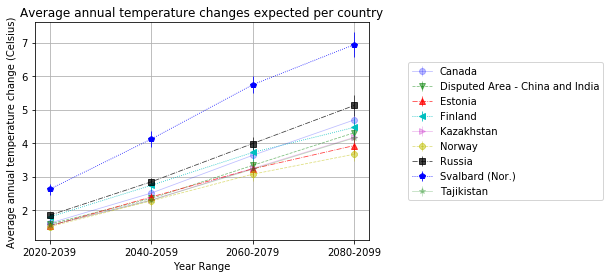

In [119]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
filled_markers = filled_markers * math.ceil(len(temperatures_df_means.columns) / len(filled_markers))
linestyles = ['solid', 'dashed', 'dashdot', 'dotted'] * math.ceil(len(temperatures_df_means.columns) / 4)
fillstyles = ['full', 'left', 'right', 'bottom','top', 'none'] * math.ceil(len(temperatures_df_means.columns) / 6)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * math.ceil(len(temperatures_df_means.columns) / 7) # exclude white of course
alphas = [0.25,0.5,0.75,1] * math.ceil(len(temperatures_df_means.columns) / 4)

art_counter = -1
for i in np.arange(len(temperatures_df_means.columns)):
    if temperatures_df_means.iloc[0,i] >= 1.5:   # Too many countries to plot... 
                                                 # let's just focus on countries 
                                                 # where the expected temp increase 
                                                 # is at least 1.5 degrees Celsius
        art_counter += 1
        plt.errorbar(np.arange(len(temperatures_df_means.index)), temperatures_df_means.iloc[:,i], 
                     yerr=temperatures_df_stderr.iloc[:,i], label=temperatures_df_means.columns[i], 
                     marker=filled_markers[art_counter], linewidth=0.8, 
                     linestyle=linestyles[art_counter], color=colours[art_counter], alpha=alphas[art_counter])
plt.title('Average annual temperature changes expected per country')
plt.xlabel('Year Range')
plt.ylabel('Average annual temperature change (Celsius)')
plt.xticks(np.arange(len(temperatures_df_means.index)),temperatures_df_means.index)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.grid()
plt.savefig("Figures/Average_annual_temp_change_prediction_per_country2_NP.png", bbox_inches='tight')
plt.show()

In [61]:
country_name = []
precip_years1 = []
precip_years2 = []
countries_precip = {}
countries_years = {} # just a temporary dictionary 
                     # that will be added as a column to the final 
                     # temperature and precipitation dataframes

for country in range(countries_in_climate_api.shape[0]):
    #print(country)
    country_name.append(countries_in_climate_api.loc[country, 'name'])
    precips = []
    precip_years1 = []
    precip_years2 = []
    for year in range(len(startyears)):
        climate_url_annualavg_pr = climate_base_url + 'annualanom/' # Average annual change (anomaly). 
                                                                      # The control period is 1961-1999 for 
                                                                      # temperature and precipitation variables, 
                                                                      # and 1961-2000 for derived statistics
        climate_url_annualavg_pr += 'pr/'
        climate_url_annualavg_pr += str(startyears[year]) + '/' 
        climate_url_annualavg_pr +=  str(endyears[year]) + '/'
        climate_url_annualavg_pr += countries_in_climate_api.loc[country, 'iso3']
        #print(climate_url_annualavg_pr)
        try:
            climate_annualavg_pr = requests.get(climate_url_annualavg_pr).json()
        except:
            continue
        #pprint(climate_annualavg_pr)
        for precip in range(len(climate_annualavg_pr)):
            precips.append(climate_annualavg_pr[precip]['annualData'][0])
            precip_years1.append(startyears[year])
            precip_years2.append(endyears[year])
    countries_precip[countries_in_climate_api.loc[country, 'name']] = precips
    countries_years[countries_in_climate_api.loc[country, 'name']] = [str(precip_years1[i]) + "-" + str(precip_years2[i])
                                                                      for i in range(len(precip_years1))]


In [53]:
# most seem to have 112 values recorded; let's check if there are any != 112
for k,v in countries_precip.items():
    if(len(v) != 112): print(k,len(v))

# no data for serbia and montenegro; 
# 3 countries are off by 1 unrecorded precipitation value
# let's take these 3 countries into a separate dataframe

Christmas Island (Aus.) 111
El Salvador 111
Tokelau (N.Z.) 111
serbia and montenegro 0


In [121]:
countries_precip2 = {}
countries_precip3 = {} # we will store the 3 countries with only 111 precipitation values here
countries_years2 = {}
countries_years3 = {}
countries_dropped = []
for k,v in countries_precip.items():
    if len(v) == 112:
        countries_precip2.update({k: v})
    elif len(v) == 111:
        countries_precip3.update({k: v})
    else:
        countries_dropped.append(k)
for k,v in countries_years.items():
    if len(v) == 112:
        countries_years2.update({k: v})
    elif len(v) == 111:
        countries_years3.update({k: v})
precipitations_df = pd.DataFrame(countries_precip2)
years_df = pd.DataFrame(countries_years2)
# all years' columns match
# adding the 'Years' column to precipitations_df 
precipitations_df['Years'] = years_df.iloc[:,0]           # (after manually verifying that 
                                                          # all countries have the same year ranges)
                                                          # not showing that code here to keep things cleaner
precipitations_df_means = precipitations_df.groupby('Years').mean()
precipitations_df_stderr = precipitations_df.groupby('Years').sem() # will be plotting the error bars as well

# Quick view of data / ensuring things are as expected:
print(precipitations_df.loc[0:4, ['Years'] + list(precipitations_df.columns)[0:4]])
print(precipitations_df.shape)
print(precipitations_df_means.iloc[0:4, 0:4])
print(precipitations_df_means.shape)
print(precipitations_df_stderr.iloc[0:4, 0:4])
print(precipitations_df_stderr.shape)


# Add the 3 countries that are off by one precipitation value:
precipitations2_df = pd.DataFrame(countries_precip3)
years2_df = pd.DataFrame(countries_years3)
precipitations2_df['Years'] = years2_df.iloc[:,0]
precipitations2_df_means = precipitations2_df.groupby('Years').mean()
precipitations2_df_stderr = precipitations2_df.groupby('Years').sem()

print("\n\n---- The 3 countries with only 111 values ------\n")
print(precipitations2_df.loc[0:4, ['Years'] + list(precipitations2_df.columns)[0:4]])
print(precipitations2_df.shape)
print(precipitations2_df_means.iloc[0:4, 0:4])
print(precipitations2_df_means.shape)
print(precipitations2_df_stderr.iloc[0:4, 0:4])
print(precipitations2_df_stderr.shape)


# Thus, we will not merge these countries or consider them further as they really skew the overall global picture
final_precipitations_means_df = pd.concat([precipitations_df_means, precipitations2_df_means], axis=1)
final_precipitations_stderr_df = pd.concat([precipitations_df_stderr, precipitations2_df_stderr], axis=1)

# Save the data:
final_precipitations_means_df.to_csv('data_output/mean_precipitation_changes_NP.csv', index=False, encoding='utf-8')
final_precipitations_stderr_df.to_csv('data_output/stderr_precipitation_changes_NP.csv', index=False, encoding='utf-8')


       Years  Afghanistan    Albania    Algeria  American Samoa (U.S.)
0  2020-2039     3.993746 -65.627954 -25.930512             -15.879176
1  2020-2039   -20.229606  -5.381035 -10.040589              51.266582
2  2020-2039   -14.589036 -32.852412 -25.187864              74.612900
3  2020-2039   -38.158703 -12.603482 -19.319011              19.486433
4  2020-2039    38.366885 -48.669384   8.173229              25.167500
(112, 238)
           Afghanistan     Albania    Algeria  American Samoa (U.S.)
Years                                                               
2020-2039    -3.513526  -42.419139  -5.331772              63.860499
2040-2059    -6.432855  -58.816210  -7.001998              87.942769
2060-2079   -21.523026  -85.910413 -15.125900              86.736434
2080-2099   -28.930377 -115.050994 -19.460954             109.103369
(4, 237)
           Afghanistan    Albania   Algeria  American Samoa (U.S.)
Years                                                             
2020-2

In [112]:
print(countries_dropped) # due to no data

['serbia and montenegro']


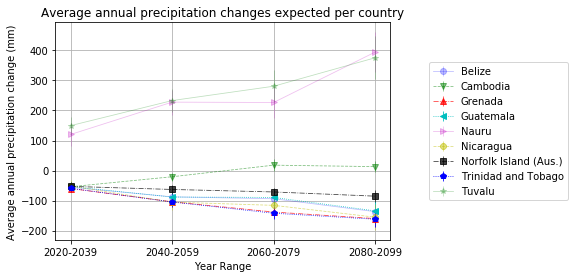

In [122]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
filled_markers = filled_markers * math.ceil(len(final_precipitations_means_df.columns) / len(filled_markers))
linestyles = ['solid', 'dashed', 'dashdot', 'dotted'] * math.ceil(len(final_precipitations_means_df.columns) / 4)
fillstyles = ['full', 'left', 'right', 'bottom','top', 'none'] * math.ceil(len(final_precipitations_means_df.columns) / 6)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * math.ceil(len(final_precipitations_means_df.columns) / 7) # exclude white of course
alphas = [0.25,0.5,0.75,1] * math.ceil(len(final_precipitations_means_df.columns) / 4)

art_counter = -1
for i in np.arange(len(final_precipitations_means_df.columns)):
    if (final_precipitations_means_df.iloc[0,i] <= -50) or (final_precipitations_means_df.iloc[0,i] >= 100):   
                                                             # Too many countries to plot... 
                                                             # let's just focus on countries 
                                                             # where the expected precipitation
                                                             # increase/decrease is at least +100/-50 mm 
        art_counter += 1
        plt.errorbar(np.arange(len(final_precipitations_means_df.index)), final_precipitations_means_df.iloc[:,i], 
                     yerr=final_precipitations_stderr_df.iloc[:,i], label=final_precipitations_means_df.columns[i], 
                     marker=filled_markers[art_counter], linewidth=0.8, 
                     linestyle=linestyles[art_counter], color=colours[art_counter], alpha=alphas[art_counter])
plt.title('Average annual precipitation changes expected per country')
plt.xlabel('Year Range')
plt.ylabel('Average annual precipitation change (mm)')
plt.xticks(np.arange(len(final_precipitations_means_df.index)),final_precipitations_means_df.index)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.grid()
plt.savefig("Figures/Average_annual_precipitation_change_prediction_per_country2_NP.png", bbox_inches='tight')
plt.show()